# Lab 3

## Business Understanding

#### Overview
This dataset is from a Kaggle competition that was collected in order to help identify different Right Whales, an endangered species. Only a handful of skilled biologists could identify these whales on sight and others would need to go through extensive observation before knowing which whale they had spotted. The purpose of this dataset is to create a machine learning model that could accurately identify a Right Whale given an aerial image.

The images themselves have been taken over a period of 10 years in many helicopter trips. Furthermore, the images are relatively high resolution and are differently sized. Biologists have identified each whale and put them into the train.csv file (the labels for our project). 

#### Importance of Data
Being able to correctly identify a Right Whale is important to tracking and monitoring each individual's health, amplified by the fact there there were only 447 whales left at the time of this competition. The speed of machine learning itself will save time and money for the scientists themselves. When the whales are in danger due to pollution or attack, the scientists can quickly do a medical history search of the whale when identified and account for any important characteristics.

When running a feature extraction filter across the pictures of the whales, if we can find any correlation between the target classes (different types of Right Whales) then we will know that the problem presented will not be too difficult and can be simply done with our method: resize, filter, vectorize, compare. Otherwise if there are no good correlation and other whales are showing up as the most closely related, then we will know that this is a non-trivial problem and will require much more pre-processing, computational power, and complex models.


## Data Preparation



In [1]:
%%time
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#opens the csv, reads the data in, and converts it to a dict where whaleID is the key and a concatenated string of image names is the value
df = pd.read_csv('./test_medium.csv')
df_dict = df.set_index('whaleID').to_dict()
df_dict = df_dict['Image']

#setup image_dict to insert images into, etc.
image_dict = {}
img_size = (200, 200)
base_link = "imgs/"

#Goes through and splits up the concatenated strings into a list of strings, then iterates through the image names associated with each whaleID
# and pulls in the image for that name, storing it in the image_dict (this is what's used eventually)
#100 of the ~450 whaleID's takes about 2-3 minutes (reasonable to do 200, which would be over 1000 images for sure, and we can easily cut out as many 
# whaleID's now to reduce the image set, because we would be cutting them out by whale, which wouldn't effect us in terms of comparison)
for whale in df_dict:
    df_dict[whale] = df_dict[whale].split(',')
    image_dict[whale] = []
    for image_name in df_dict[whale]:
        link = base_link + str(image_name)
        img = Image.open(link)
        img = img.resize(img_size)
        img = img.convert("L")   #greyscaling
        image_dict[whale].append(img)        
## Now the data is in a large dictionary where the whaleID is the key and the values are a list of images associated with that whaleID



Wall time: 5min 49s


In [2]:
df = pd.DataFrame(columns=('whale_id', 'org_img', 'vector_image'))
counter = 0
for x in image_dict.keys():
    pic_list = image_dict[x]
    for i in pic_list:
        v = np.array(i).reshape(img_size[0]*img_size[1],)
        df.loc[counter] = [x, i, v]
        counter += 1

In [3]:
#convert to data frame in case we want that instead!
df.shape
num_images = df.shape[0]

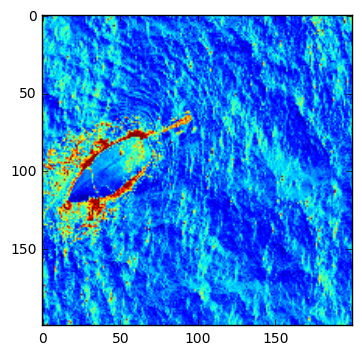

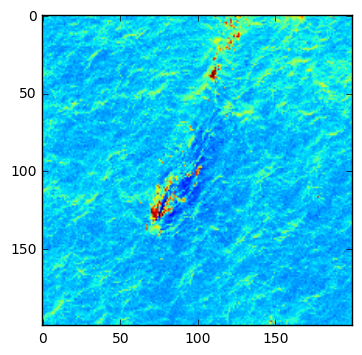

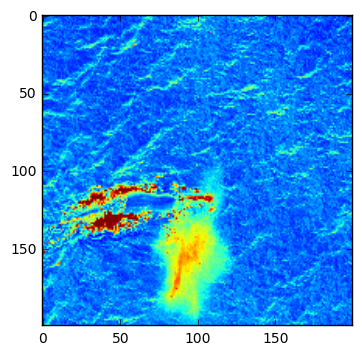

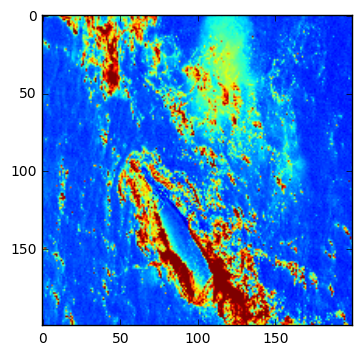

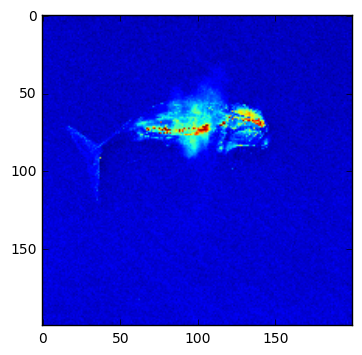

In [4]:
%matplotlib inline
from random import randrange

for x in range(0, 5):
    i = randrange(0, df.shape[0])
    plt.imshow(df.loc[i].org_img)
    plt.show()


Images are resized to 200x200 for computational purposes as it seems to keep a still good resolution and grayscaled to reduce the vector size from 200 * 200 * 3 to 200x200. They are then put into a numpy array. 5 random images from the dataset are shown.

#### PCA

In [5]:
# df.vector_image.values.ravel()
vector = df.vector_image
stacked = np.vstack(vector)

In [6]:
from sklearn.decomposition import PCA
n_components = 50   # ~90% variance
pca = PCA(n_components=n_components)
pca.fit(stacked)
eigen = pca.components_.reshape((n_components, 200, 200))


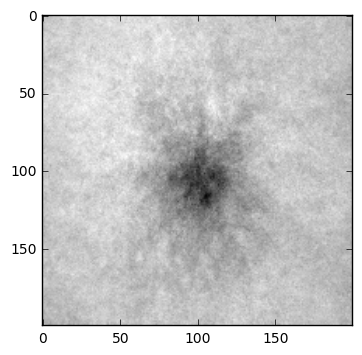

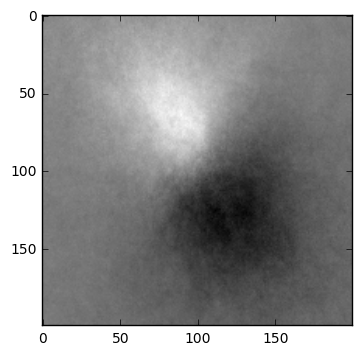

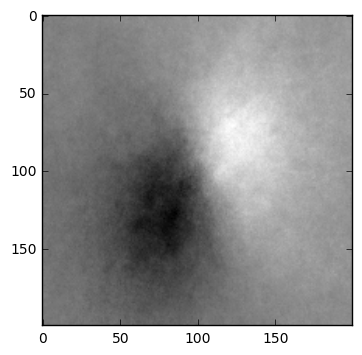

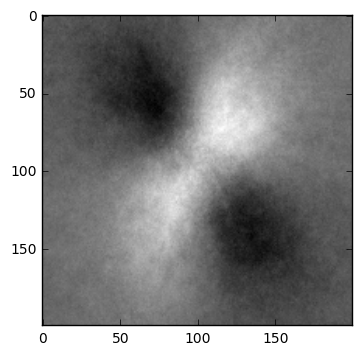

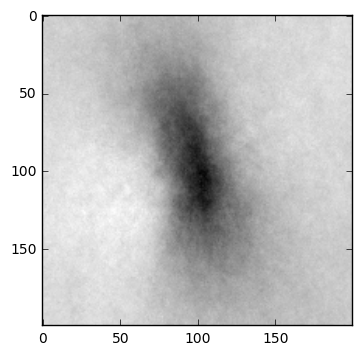

In [7]:
for x in range(0, 5):
    plt.imshow(eigen[x], cmap=plt.cm.gray)
    plt.show()

Above are the top 5 eigenimages when PCA is run over it.

In [8]:
def plot_explained_variance(pca):    #from eclarson notebook 4
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
      

In [9]:
plot_explained_variance(pca)

With 337 components, we can capture 90% of the data, which we thought was appropriate for this dataset.

#### Random PCA

In [10]:
# RANDOM PCA
from sklearn.decomposition import RandomizedPCA

rn_components = 25

rpca = RandomizedPCA(n_components=rn_components)
%time rpca.fit(stacked)
eigen = rpca.components_.reshape((rn_components, img_size[0], img_size[1]))

Wall time: 2 s


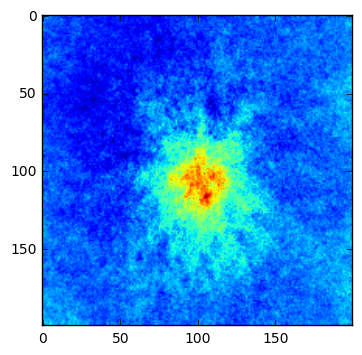

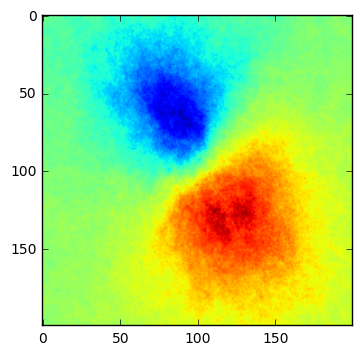

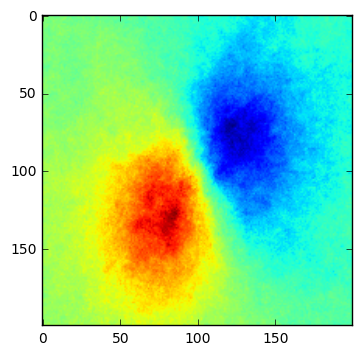

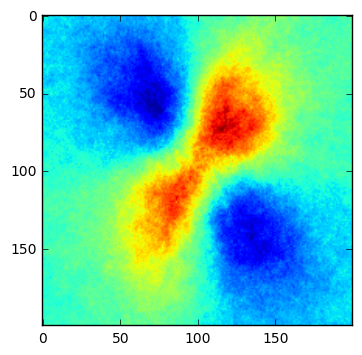

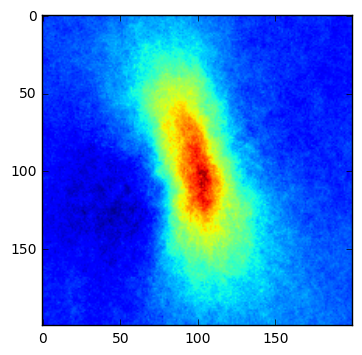

In [11]:
for x in range(0, 5):
    plt.imshow(eigen[x])
    plt.show()


Above are the top 5 images for a Random PCA

#### Kernal PCA

In [12]:
from sklearn.decomposition import KernelPCA

kn_components = 25
kpca = KernelPCA(n_components=kn_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(stacked)

Wall time: 6.58 s


KernelPCA(alpha=1.0, coef0=1, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=25,
     remove_zero_eig=False, tol=0)

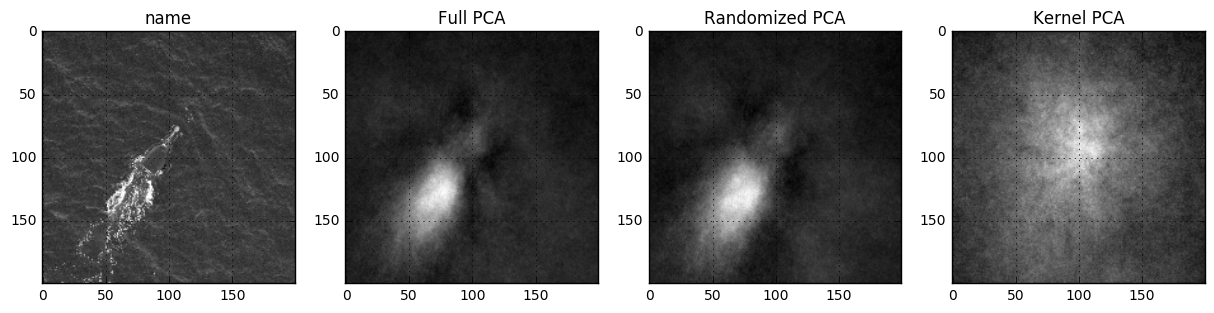

In [13]:
import warnings
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist

warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods

h = img_size[1]
w = img_size[0]

def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(stacked[idx_to_reconstruct]))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(stacked[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(stacked[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,8))
    
    plt.subplot(2,4,1)
    plt.imshow(stacked[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
#     plt.title(names[y[idx_to_reconstruct]])
    plt.title("name")
    plt.grid()
    
    plt.subplot(2,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(2,4,3)
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid()
    
    plt.subplot(2,4,4)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,num_images-1,1),__manual=True)

Above are all the reconstructed images of each PCA side by side.

In [14]:
rpca_mean = []
kpca_mean = []
pca_mean = []
test = []
for x in stacked:
    
    temp = np.array([x, pca.inverse_transform(pca.transform(x))[0]])
    pca_mean.append(pdist(temp, 'euclidean')[0])
    
    temp = np.array([x, rpca.inverse_transform(rpca.transform(x))[0]])
    rpca_mean.append(pdist(temp, 'euclidean')[0])
    
    temp = np.array([x, kpca.inverse_transform(kpca.transform(x))[0]])
    kpca_mean.append(pdist(temp, 'euclidean')[0])

print("Mean of PCA: {}".format(np.mean(pca_mean)))
print("Mean of RPCA: {}".format(np.mean(rpca_mean)))
print("Mean of KPCA: {}".format(np.mean(kpca_mean)))


Mean of PCA: 3195.4854700261053
Mean of RPCA: 3370.0137898761373
Mean of KPCA: 5949.008653823945


### Conclusion

## Feature Extraction

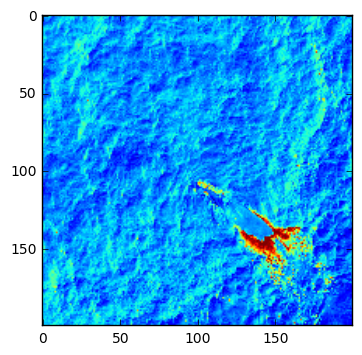

In [15]:
single_img = df.org_img[7]

plt.imshow(single_img)

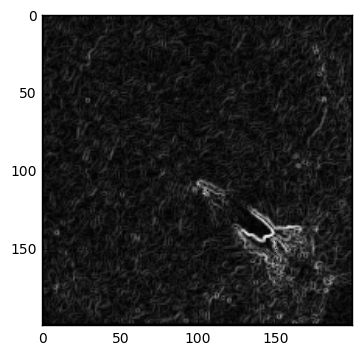

In [16]:
from skimage.filters import sobel_h, sobel_v


gradient_mag = np.sqrt(sobel_v(single_img)**2 + sobel_h(single_img)**2 ) 
plt.imshow(gradient_mag, cmap=plt.cm.gray)
plt.grid()

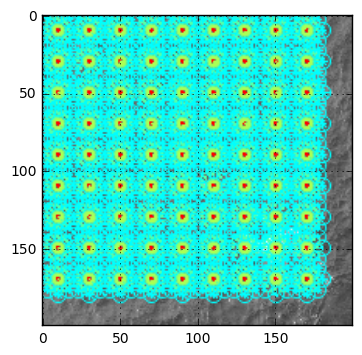

In [17]:
from skimage.feature import daisy

# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(single_img,step=20, radius=10, rings=3, histograms=8, orientations=8, visualize=True)
plt.imshow(img_desc)
plt.grid()

In [18]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))


In [19]:
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, stacked, img_size)
print(daisy_features.shape)

Wall time: 2min
(2251, 33696)


In [20]:
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

Wall time: 1.77 s


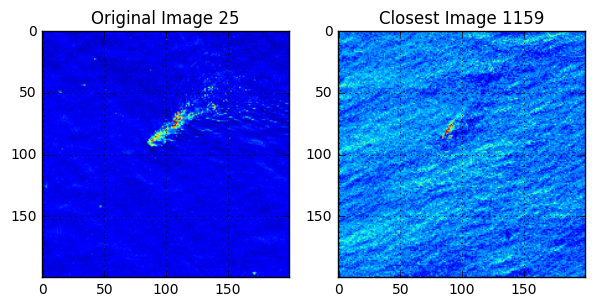

In [21]:
import copy
# find closest image to current image
idx1 = 25
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
plt.imshow(stacked[idx1].reshape(img_size))
plt.title("Original Image " + str(idx1))
plt.grid()

plt.subplot(1,2,2)
plt.imshow(stacked[idx2].reshape(img_size))
plt.title("Closest Image " + str(idx2))
plt.grid()

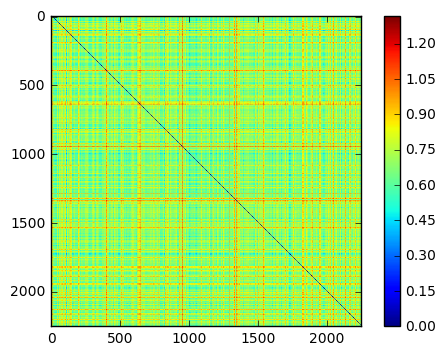

In [22]:
plt.imshow(dist_matrix)
plt.colorbar()